In [ ]:
#%pip install mlxtend  
#from mlxtend.evaluate import bias_variance_decomp
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv('clean_kaggle_data_2022.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN,NaN
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"


# **Question 1**: Data Cleaning

In [ ]:
# seperate Multiple choice questions from written answers 
Written_Question = []
MCQ_Question = []

for i in df.columns:
  if '_' not in i:
    Written_Question.append(i)
  if '_' in i:
    MCQ_Question.append(i)

# Note that the 2 added columns for bucks and encoded buckets contain a '_' in the columns name but are not MCQ questions.
MCQ_Question.remove('Q29_buckets')
MCQ_Question.remove('Q29_Encoded')



In [ ]:
MCQ_Data = df[MCQ_Question]
MCQ_Data_raw = MCQ_Data.drop(index = 0) #remove the first line, i.e, the question from the list.
MCQ_Data_raw.fillna(0, inplace = True)
MCQ_Data_raw.head()

# Encode MCQ_Data_Raw with 1 representing and answer and 0 representing a NaN
MCQ_Data_raw_Encoded = pd.get_dummies(MCQ_Data_raw) #remove the first line, i.e, the question from the list.
MCQ_Data_raw_Encoded.head()


,Q6_1_0,Q6_1_Coursera,Q6_2_0,Q6_2_edX,Q6_3_0,Q6_3_Kaggle Learn Courses,Q6_4_0,Q6_4_DataCamp,Q6_5_0,Q6_5_Fast.ai,...,Q44_8_0,"Q44_8_Blogs (Towards Data Science, Analytics Vidhya, etc)",Q44_9_0,"Q44_9_Journal Publications (peer-reviewed journals, conference proceedings, etc)",Q44_10_0,"Q44_10_Slack Communities (ods.ai, kagglenoobs, etc)",Q44_11_0,Q44_11_None,Q44_12_0,Q44_12_Other
1,0,1,1,0,0,1,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
2,0,1,0,1,1,0,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
3,0,1,1,0,0,1,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,1,0,0,1,...,0,1,1,0,1,0,1,0,1,0
5,0,1,1,0,1,0,1,0,1,0,...,0,1,0,1,1,0,1,0,1,0


In [ ]:
# Work with Written Questions

Written_Question_Data = df[Written_Question] #Look for empty answers in Written questions
Written_Question_Data_raw = Written_Question_Data.drop(index = 0)
Written_Question_Data_raw.isna().sum() 

#if column has more than 50% of missing answers then it should be dropped as it is not possible to fill this data without creating bias in the results.
for i in Written_Question_Data_raw.columns:
  prop = (Written_Question_Data_raw[i].isna().sum())/len(Written_Question_Data_raw[i])*100
  if prop >=50:
    Written_Question_Data_raw = Written_Question_Data_raw.drop(columns = i )

Written_Question_Data_raw.isna().sum()

Duration (in seconds)       0
Q2                          0
Q3                          0
Q4                          0
Q5                          0
Q8                          0
Q9                       2941
Q11                         0
Q16                       684
Q23                         0
Q24                         0
Q25                         0
Q26                         0
Q27                         0
Q29                         0
Q30                        50
Q43                      3723
dtype: int64

In [ ]:
print('The answers for written question Q9 are: {}'.format(Written_Question_Data_raw['Q9'].unique()))
print('\nThe answers for written question Q16 are: {}'.format(Written_Question_Data_raw['Q16'].unique()))
print('\nThe answers for written question Q30 are: {}'.format(Written_Question_Data_raw['Q30'].unique()))
print('\nThe answers for the written question Q43 are: {}'.format(Written_Question_Data_raw['Q43'].unique()))

The answers for written question Q9 are: [nan 'Yes' 'No']

The answers for written question Q16 are: ['1-2 years' '4-5 years' '5-10 years' '2-3 years' 'Under 1 year'
 '3-4 years' '10-20 years' 'I do not use machine learning methods' nan]

The answers for written question Q30 are: ['$1000-$9,999' '$0 ($USD)' '$100-$999' '$100,000 or more ($USD)' '$1-$99'
 '$10,000-$99,999' nan]

The answers for the written question Q43 are: ['2-5 times' nan 'Never' 'More than 25 times' 'Once' '6-25 times']


In [ ]:
# for Q9 and Q43, a relatively good amount of data is empty
prop_Q9 = (Written_Question_Data_raw['Q9'].isna().sum())/len(Written_Question_Data_raw['Q9'])*100
prop_Q43 = (Written_Question_Data_raw['Q43'].isna().sum())/len(Written_Question_Data_raw['Q43'])*100

print('The proportion of empty data in Q9 and Q43 are: \nQ9:{}\nQ43:{}'.format(prop_Q9,prop_Q43))

# We can not randomly assigin a answer to those missing values as it would affect the accuracy of our machine learning algorithm, 
#Therefore we would assing a value of 0 for empty answers. 
Written_Question_Data_raw['Q9'].fillna(0,inplace = True)
Written_Question_Data_raw['Q43'].fillna(0,inplace = np.True_)
Written_Question_Data_raw.isnull().sum() #check for updated written question dataset


The proportion of empty data in Q9 and Q43 are: 
Q9:0.0
Q43:0.0




Duration (in seconds)      0
Q2                         0
Q3                         0
Q4                         0
Q5                         0
Q8                         0
Q9                         0
Q11                        0
Q16                      684
Q23                        0
Q24                        0
Q25                        0
Q26                        0
Q27                        0
Q29                        0
Q30                       50
Q43                        0
dtype: int64

In [ ]:
df1 = df.drop(index = 0) # drop the first row which includes the question 
df1.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"
5,679,40-44,Man,United States of America,No,Coursera,NaN,NaN,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...","Journal Publications (peer-reviewed journals, ...",NaN,NaN,NaN,13.0,"200,000-299,999"


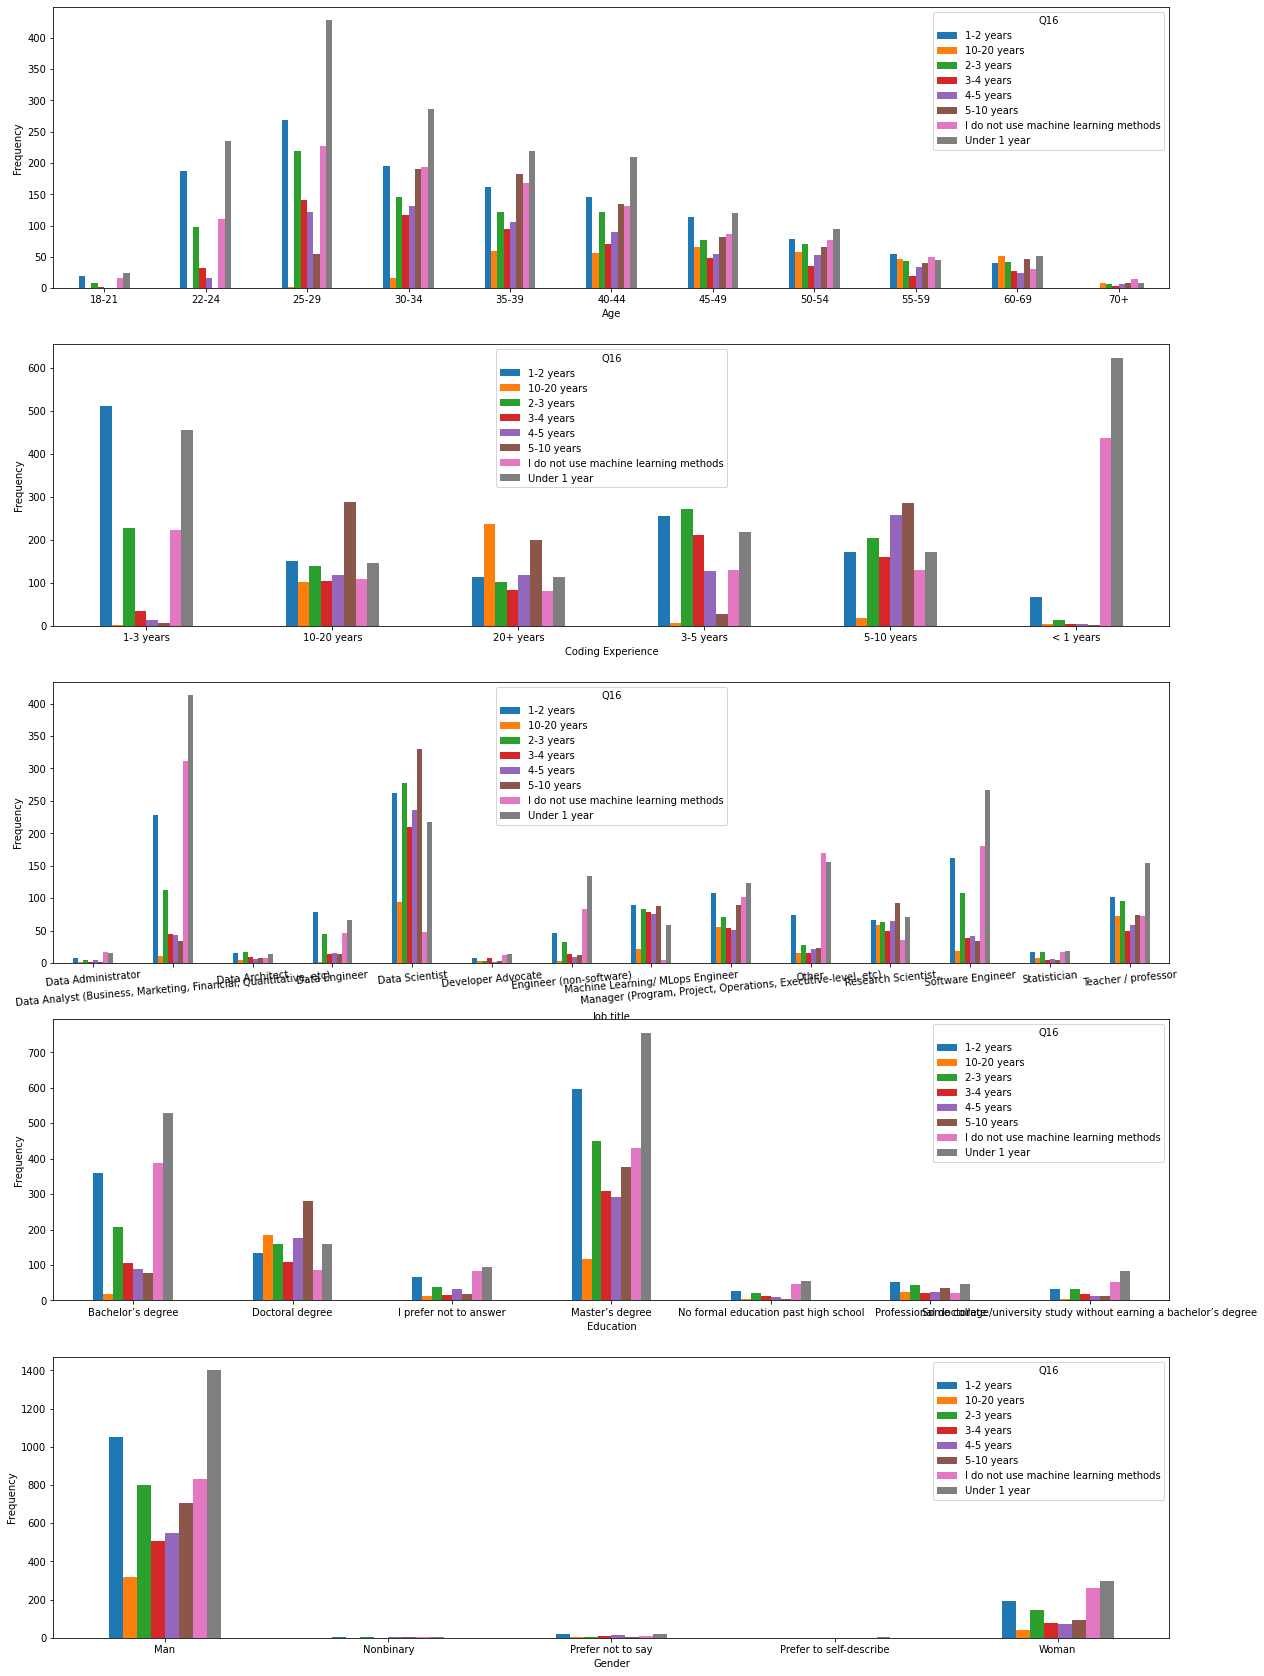

In [ ]:
# 2 remaining columns are to be analyzed, Q16 and Q30

Written_Question_Data_raw['Q16'].unique() 
# Look factors that influence this answer the most, we will look at age, years of experience in coding, job title and education and gender
# plot distribution of those features with respect to our question of interest to visualize factors that affect the distribution of Q['16'] the most
df = df.drop(index = 0)
fig,axes=plt.subplots(5,1)
ML_Age = (df['Q16'].groupby(df['Q2'],axis=0).value_counts()).unstack()
ML_Experience=(df['Q16'].groupby(df['Q11'],axis=0).value_counts()).unstack()
ML_Job=(df['Q16'].groupby(df['Q23'],axis=0).value_counts()).unstack()
ML_Education=(df['Q16'].groupby(df['Q8'],axis=0).value_counts()).unstack()
ML_Gender=(df['Q16'].groupby(df['Q3'],axis=0).value_counts()).unstack()
ML_Age.plot.bar(ax=axes[0],figsize=(20,30),rot=0,xlabel='Age',ylabel='Frequency')
ML_Experience.plot.bar(ax=axes[1],figsize=(20,30),rot=0,xlabel='Coding Experience',ylabel='Frequency')
ML_Job.plot.bar(ax=axes[2],figsize=(20,30),rot=5,xlabel='Job title',ylabel='Frequency')
ML_Education.plot.bar(ax=axes[3],figsize=(20,30),rot=0,xlabel='Education',ylabel='Frequency')
ML_Gender.plot.bar(ax=axes[4],figsize=(20,30),rot=0,xlabel='Gender',ylabel='Frequency')


**Observation**: gender, occupation and level of education affect the data the most. To be validated using a covarirance matrix implemented in subsequent section.


In [ ]:
df.at[((df['Q23']=='Data Analyst (Business, Marketing, Financial, Quantitative, etc)')|(df['Q23']=='Data Scientist')|(df['Q23']=='Software Engineer'))&((df['Q8']=='Master’s degree')|(df['Q8']=='Bachelor’s degree'))&df['Q16'].isnull(),'Q16']='1-2 years'
df.at[((df['Q11']=='10-20 years')|(df['Q11']=='5-10 years')|(df['Q11']=='20+ years'))&(df['Q23']=='Data Scientist')&df['Q16'].isnull(),'Q16']='5-10 years'
df.at[((df['Q2']=='22-24')|(df['Q2']=='25-29')|(df['Q2']=='30-34')|(df['Q2']=='35-39')|(df['Q2']=='40-44'))&((df['Q11']=='< 1 years')|(df['Q11']=='1-3 years'))&df['Q16'].isnull(),'Q16']='Under 1 year'
df.at[((df['Q23']=='Engineer (non-software)')|(df['Q23']=='Other')|(df['Q23']=='Teacher / professor'))&((df['Q8']=='Master’s degree')|(df['Q8']=='Bachelor’s degree'))&df['Q16'].isnull(),'Q16']='Under 1 year'
df['Q16'].isnull().value_counts()

False    7802
True      334
Name: Q16, dtype: int64

**Note**: We were able to reduce the number of unanswered questions from 684 to 334 with logical conclusions made from the graphs shown above, the remaining nan values would be filled with a 0 as no logical conclusion allowed us to fill those missing answers 

In [ ]:
df['Q16'].fillna(0, inplace = True)
df['Q16'].unique()
Written_Question_Data_raw['Q16'] = df['Q16']
Written_Question_Data_raw['Q16'].isnull().sum()

0

Similar approch is adopted for the 50 missing values in Q30

In [ ]:
# Looking for unique answers in Q30
df['Q30'].unique()

array(['$1000-$9,999', '$0 ($USD)', '$100-$999',
       '$100,000 or more ($USD)', '$1-$99', '$10,000-$99,999', nan],
      dtype=object)

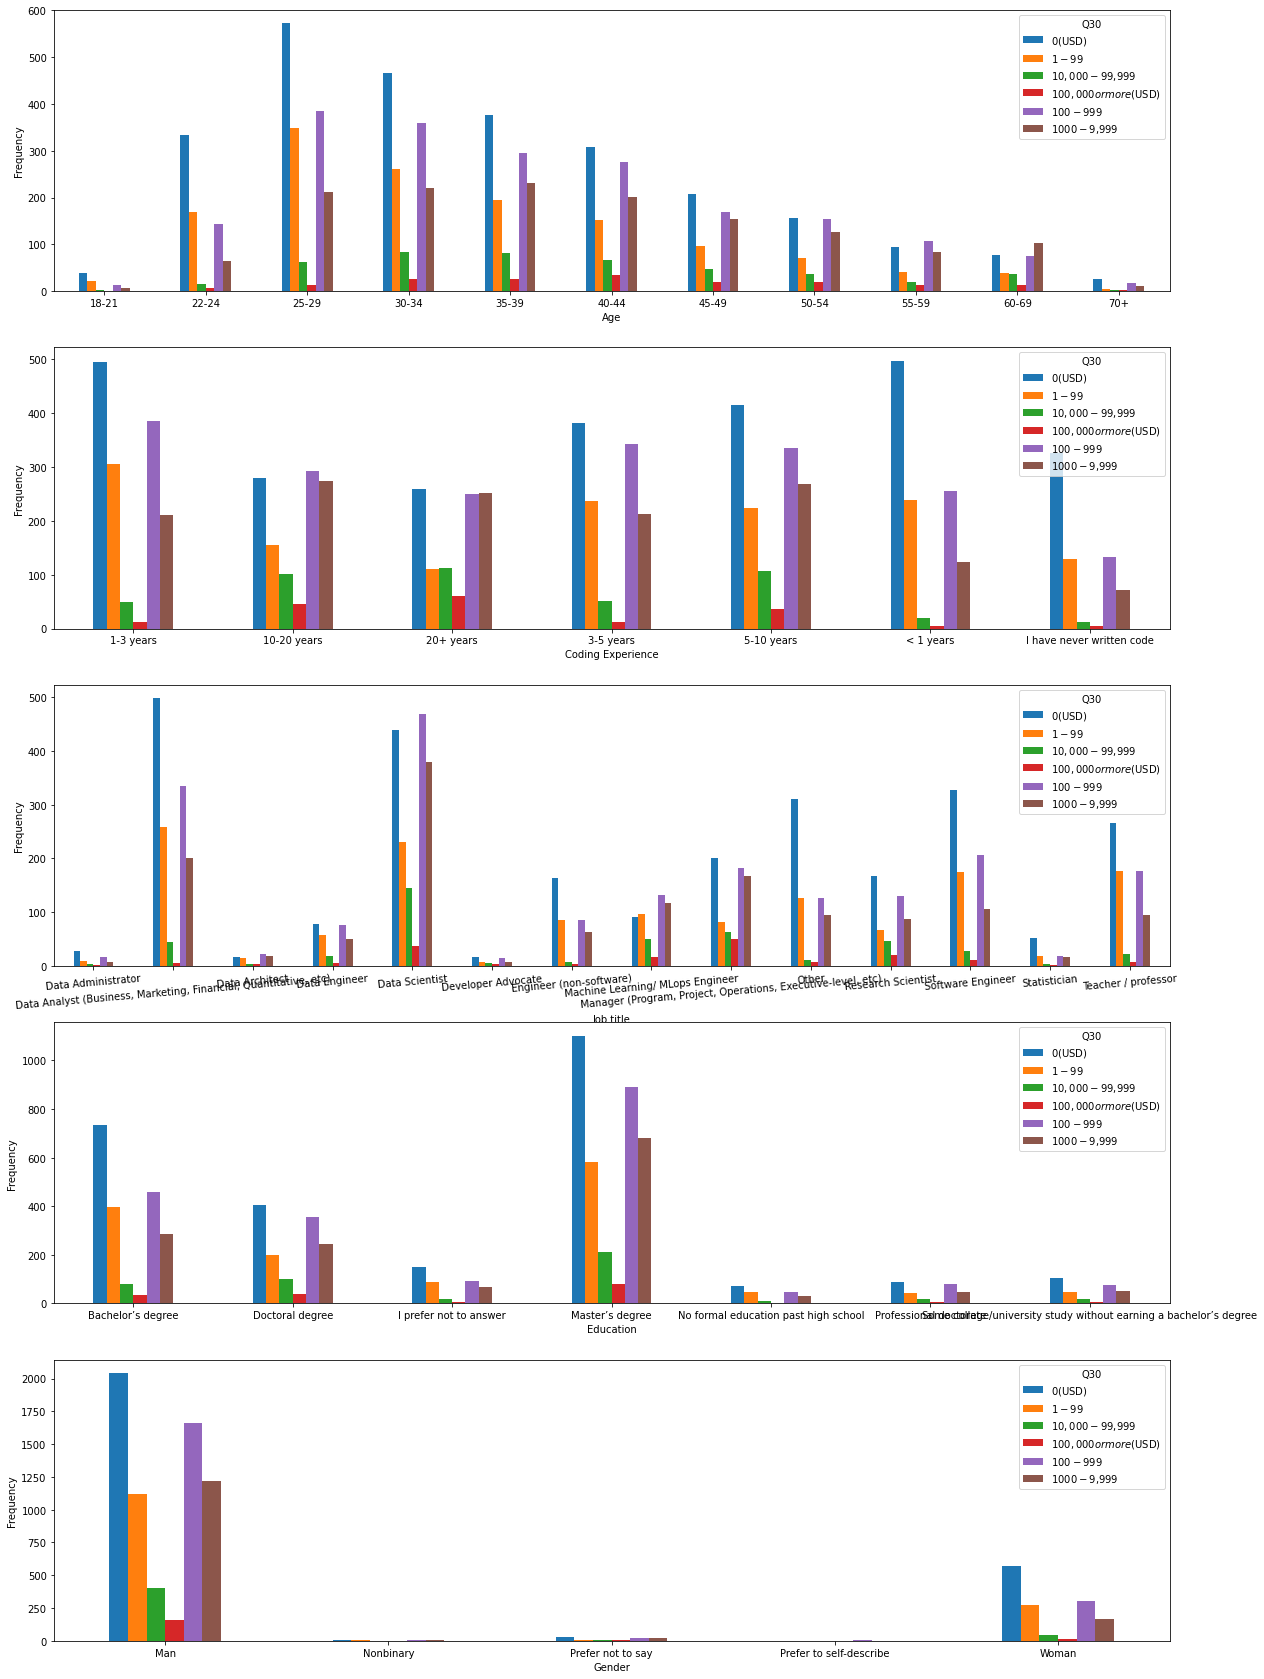

In [ ]:
#below we are plotting our question of interest Q['30'] grouped by features such as age, experience etc... to see the distribution and effect of each 
#feature on our question of interest in order to know how to possibly deal with missing data.
fig,axes=plt.subplots(5,1)
Spend_Age = (df['Q30'].groupby(df['Q2'],axis=0).value_counts()).unstack()
Spend_Experience=(df['Q30'].groupby(df['Q11'],axis=0).value_counts()).unstack()
Spend_Job=(df['Q30'].groupby(df['Q23'],axis=0).value_counts()).unstack()
Spend_Education=(df['Q30'].groupby(df['Q8'],axis=0).value_counts()).unstack()
Spend_Gender=(df['Q30'].groupby(df['Q3'],axis=0).value_counts()).unstack()
Spend_Age.plot.bar(ax=axes[0],figsize=(20,30),rot=0,xlabel='Age',ylabel='Frequency')
Spend_Experience.plot.bar(ax=axes[1],figsize=(20,30),rot=0,xlabel='Coding Experience',ylabel='Frequency')
Spend_Job.plot.bar(ax=axes[2],figsize=(20,30),rot=5,xlabel='Job title',ylabel='Frequency')
Spend_Education.plot.bar(ax=axes[3],figsize=(20,30),rot=0,xlabel='Education',ylabel='Frequency')
Spend_Gender.plot.bar(ax=axes[4],figsize=(20,30),rot=0,xlabel='Gender',ylabel='Frequency')


In [ ]:
df.at[((df['Q11']=="1-3 years")|(df['Q11']=="3-5 years")|(df['Q11'] == "5-10 years"))&((df['Q23']=="Data Scientist")|(df['Q23']=="Data Analyst (Business, Marketing, Financial, Quantitative, etc)"))&df['Q23'].isnull(),'Q30'] = '$100-$999'
df.at[((df['Q8']=="Bachelor’s degree")|(df['Q8']=="Master’s degree")|(df['Q8']=="Doctoral degree"))&((df['Q23']=="Data Scientist")|(df['Q8']=='Machine Learning/ MLops Enginee'))&df['Q30'].isnull(),'Q30'] = '$1000-$9,999'
df['Q30'].isnull().sum()

43

Similarly, we were able to reduce the number from 50 to 43 based on logical assumptions, the remaining Nans will be filled by a zero

In [ ]:
df['Q30'].fillna(0,inplace = True)
df['Q30'].unique()
Written_Question_Data_raw['Q30'] = df['Q30'] # replace computed values in Written question data array 
Written_Question_Data_raw['Q30'].isnull().sum()

0

In [ ]:
Written_Question_Data_raw.columns

Index(['Duration (in seconds)', 'Q2', 'Q3', 'Q4', 'Q5', 'Q8', 'Q9', 'Q11',
       'Q16', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q29', 'Q30', 'Q43'],
      dtype='object')

In [ ]:
#checking for any missing values in Written Questions array
print(Written_Question_Data_raw.isnull().sum())
#the data is clean, and can therefore be encoded now. 
#drop the first column of time taken to complete the survey.

Written_Question_Data_raw = Written_Question_Data_raw.drop(columns = 'Duration (in seconds)' )

Duration (in seconds)    0
Q2                       0
Q3                       0
Q4                       0
Q5                       0
Q8                       0
Q9                       0
Q11                      0
Q16                      0
Q23                      0
Q24                      0
Q25                      0
Q26                      0
Q27                      0
Q29                      0
Q30                      0
Q43                      0
dtype: int64


In [ ]:
Written_Question_Data_raw_Encoded = pd.get_dummies(Written_Question_Data_raw)
Written_Question_Data_raw_Encoded.shape

(8136, 187)

In [ ]:
Written_Question_Data_raw_Encoded.head()

,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,Q2_60-69,...,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999",Q43_0,Q43_2-5 times,Q43_6-25 times,Q43_More than 25 times,Q43_Never,Q43_Once
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
# Concatenate both encoded datasets:

MCQ_Data_raw_Encoded_test  = MCQ_Data_raw_Encoded #just in case to keep both MCQ and Written Questions datasets encoded intact
Written_Question_Data_raw_Encoded_test = Written_Question_Data_raw_Encoded

    
Final_Clean_Encoded_Data = pd.concat([MCQ_Data_raw_Encoded_test ,Written_Question_Data_raw_Encoded_test ], axis = 1)
Final_Clean_Encoded_Data

# **Question 2: Feature Selection**

In order to choose the best features representing the data, we choose to create a correlation matrix in order to visualize the effect of categories on interest on our variable of interest, i.e., salary bucket encoded. 

First we encode the data provided in order to be able to generate a covariance matrix. Encoded bukcet and all other feature vectors should have the same size

In [ ]:
#Check for correlation tmrw
salarybuck_encoded = df['Q29_Encoded'] 

#gender_encoded
map_dict_gender={'Woman':1,
         'Prefer to self-describe':0,
         'Man':2,
         'Prefer not to say':3,
          'Nonbinary':4}
gender_encoded = df['Q3'].map(map_dict_gender)

# similarly for education
map_dict_education = {'Some college/university study without earning a bachelor’s degree':1,
       'Bachelor’s degree':2, 'Doctoral degree':3, 'Master’s degree':4,
       'I prefer not to answer':5, 'No formal education past high school':6,
       'Professional doctorate':7}
education_encoded = df['Q8'].map(map_dict_education)

# years of coding experience
map_dict_codingExperience = {'10-20 years':6, '20+ years':7, '5-10 years':5, '3-5 years':4, '< 1 years':2,
       '1-3 years':3, 'I have never written code':1}
experience_encoded = df['Q11'].map(map_dict_codingExperience)

# Job position
map_dict_job = {'Data Scientist':1, 'Software Engineer':2, 'Research Scientist':3,
       'Developer Advocate':4,'Data Analyst (Business, Marketing, Financial, Quantitative, etc)':5,
       'Data Engineer':6, 'Other':7, 'Machine Learning/ MLops Engineer':8,
       'Engineer (non-software)':9, 'Teacher / professor':10,
       'Manager (Program, Project, Operations, Executive-level, etc)':11,
       'Statistician':12, 'Data Administrator':13, 'Data Architect':14} 
job_encoded = df['Q23'].map(map_dict_job)

#age
map_dict_age = {'55-59':9, '30-34':4, '70+':11, '40-44':6, '50-54':8, '25-29':3, '60-69':10,
       '35-39':5, '22-24':2, '45-49':7, '18-21':1}
age_encoded = df['Q2'].map(map_dict_age)

#Experience in Ml methods
map_dict_MLEXp = {'1-2 years':1, '4-5 years':2, '5-10 years':3, '2-3 years':4,
       'Under 1 year':5, '3-4 years':6, '10-20 years':7,
       'I do not use machine learning methods':8}
MLExp_Encoded = df['Q16'].map(map_dict_MLEXp)
MLExp_Encoded.fillna(0,inplace = True)


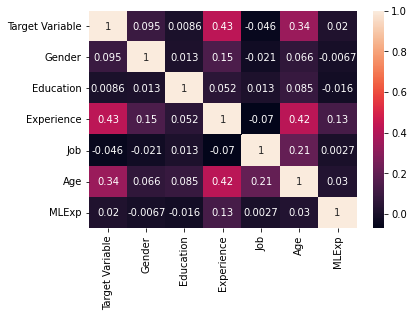

In [ ]:
Correlation_Data = pd.concat([salarybuck_encoded,gender_encoded,education_encoded,experience_encoded,job_encoded,age_encoded,MLExp_Encoded], axis = 1)
Correlation_Data  = Correlation_Data .rename(columns = {'Q29_Encoded':'Target Variable', 'Q3':'Gender', 'Q8':'Education', 'Q11':'Experience', 'Q23':'Job', 'Q2':'Age', 'Q16':'MLExp'})
sns.heatmap(Correlation_Data.corr('spearman'), annot = True)

In [ ]:
df['Q29_Encoded']
ML_Data = df[['Q2','Q3','Q4','Q8','Q11','Q16','Q23','Q30']]
ML_data_Encoded = pd.get_dummies(ML_Data)
ML_data_Encoded = pd.concat([df['Q29_Encoded'], ML_data_Encoded], axis = 1)
ML_data_Encoded

,Q29_Encoded,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,...,Q23_Software Engineer,Q23_Statistician,Q23_Teacher / professor,Q30_0,Q30_$0 ($USD),Q30_$1-$99,"Q30_$10,000-$99,999","Q30_$100,000 or more ($USD)",Q30_$100-$999,"Q30_$1000-$9,999"
1,2.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,10.0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,10.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,13.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,13.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,10.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8133,0.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8134,0.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8135,2.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#Split the data for training and testing:
X = ML_data_Encoded.drop(columns = 'Q29_Encoded')
y = ML_data_Encoded.Q29_Encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30)


In [ ]:
#fitting the data with ordinal logistic regression
logreg = LogisticRegression(C = 1 , penalty='l1', max_iter=5000, solver='saga')
logreg.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=5000, penalty='l1', solver='saga')

mse, bias, var = bias_variance_decomp(model_lr, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=123)


In [ ]:
# cross validating using logreg and 10 fold cross validation using Accuracy
fold_accuracy = cross_val_score(logreg,X_train,y_train,cv=10,scoring = 'accuracy')
fold_accuracy

In [ ]:
#wihtout the learning algorithm, the probability of belonging to a salary bucket based on the data distribution is
print(y.value_counts(normalize=True))

## Verfifying model performace before tuning 

In [ ]:
y_pred = logreg.predict(X_test)
y_pred
MSE = np.square(np.subtract(y_test,y_pred)).mean()
rsme = pow(MSE,0.5)
rsme

3.5568801846624933

In [ ]:
y_train2 = np.array(y_train)
y_test2 = np.array(y_test)
X_train2 = np.array(X_train)
X_test2 = np.array(X_test)

In [ ]:
# the below part has been done manually by varying the value of C, it was crashing when implemented in a loop for some reason. 
mse_array = []
bias_array = []
var_array = []
mse,bias,var = bias_variance_decomp.bias_variance_decomp(LogisticRegression(C=100 , max_iter = 5000), X_train2, y_train2, X_test2, y_test2, loss='mse')


mse_array.append(mse)
bias_array.append(bias)
var_array.append(var)
# for C = 100; [ ]
# for C = 10; [12.54 , 9.98 , 2.566 ]
# for C = 1 ; [12.65 , 10.313, 1.338 ]
# for C=0.1 ; [14.80 , 12.99, 1.802 ] 
# for C = 0.01; [23.87 , 22.90, 0.967 ]
# for C = 0.001; [33.567, 33.567, 0.0  ]

C = [0.001, 0.01, 0.1, 1, 10]


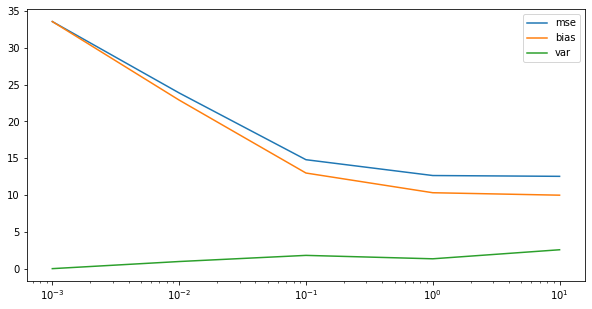

In [ ]:
C = [0.001, 0.01, 0.1, 1 , 10]
mse_ = [33.567 , 23.87, 14.8, 12.65, 12.54]
bias_ = [33.567 , 22.9, 12.99, 10.313, 9.98]
var_ = [0.0 , 0.967, 1.802, 1.338, 2.566]


fig = plt.figure()
fig.set_size_inches(10,5)
plt.xscale('log')
plt.plot(C , mse_)
plt.plot(C , bias_)
plt.plot(C, var_)
plt.legend(['mse','bias','var'])

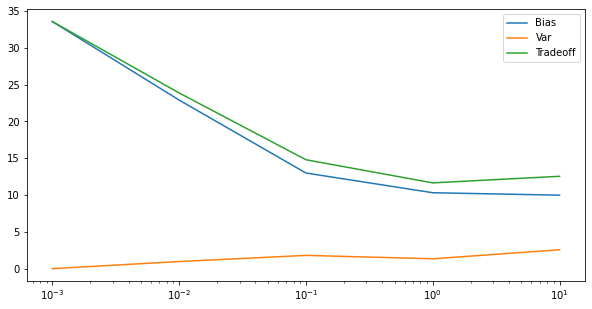

In [ ]:
#visualizing bias variance tradeoff
Bias_Var_Tradeoff = [33.567 , 23.867, 14.792, 11.651, 12.546]
fig = plt.figure()
fig.set_size_inches(10,5)
plt.xscale('log')
plt.plot(C , bias_)
plt.plot(C , var_)
plt.plot(C , Bias_Var_Tradeoff)
plt.legend(['Bias','Var','Tradeoff'])

It can be seen from the graph that the optimal tradeoff is possible for hyperparameter value of 1

In [ ]:
#Checking if accuracy of regression would change by standardizing the data. (due to difference in array size of countries and others)
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
logreg1 = LogisticRegression(C = 1 , penalty='l1', max_iter=5000, solver='saga')
X_train_Standard = scaler.transform(X_train)
logreg1.fit(X_train_Standard, y_train)

#Standardization should not change the results by much because data is not nromally distributed

LogisticRegression(C=1, max_iter=5000, penalty='l1', solver='saga')

In [ ]:
cross_val_score(logreg1,X_train_Standard,y_train,cv=10,scoring = 'accuracy')

array([0.41941392, 0.40183486, 0.42385321, 0.4146789 , 0.42752294,
       0.37431193, 0.42568807, 0.42018349, 0.41834862, 0.42201835])

# **Model Tuning**: Grid Search Implementation and Confusion Matrix


In [ ]:

# the two hyperparameters to optmizie are the penalty and the the C value

grid={"C":[0.01, 0.1, 1, 10], "penalty":["l2"]}
logreg2=LogisticRegression(max_iter = 5000)
logreg_cv=GridSearchCV(logreg2,grid,cv=10,error_score = 'raise')
logreg_cv.fit(X_train,y_train)


GridSearchCV(cv=10, error_score='raise',
             estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2'}
accuracy : 0.41717074973955715


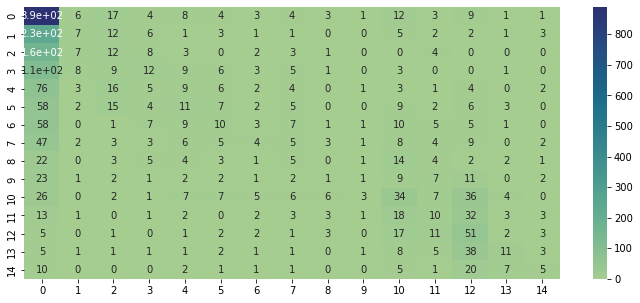

In [ ]:
y_pred = logreg_cv.predict(X_test)
Confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12,5))
sns.heatmap(Confusion_matrix, annot=True, cmap = 'crest')

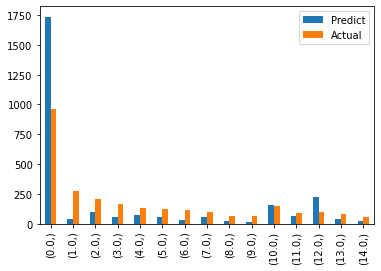

In [ ]:
y_test_plot=pd.DataFrame(y_test).value_counts()
y_pred_plot = pd.DataFrame(y_pred).value_counts()

y_plot = pd.concat([y_pred_plot, y_test_plot], axis =1).plot(kind = 'bar')
plt.legend(['Predict','Actual'])
